## 자동미분 - AUTOGRAD : AUTOMATIC DIFFERENTIATION
##### PyTorch에서 모든 신경망의 중심에는 자동미분(autograd) 패키지입니다.
##### autograd 패키지는 Tensor에 대한 모든 연산에 자동 미분을 제공합니다.
##### 이는 실행-기반-정의(define-by-run) 프레임워크로, 코드가 어떻게 작동되는지에 따라 backprop가 정의되고, 모든 단일 반복이 다르다는 의미입니다. (역전파는 학습 과정의 매 단계마다 달라집니다.)

## Tensor
##### torch.Tensor는 패키지의 핵심 클래스입니다.
##### 만약 True로서 .requires_grad 속성을 설정하면, 이에 대한 모든 연산들을 추적하기 시작합니다.
##### 계산이 끝났을 때 .backward()를 호출하여, 자동으로 모든 기울기(gradient)를 계산할 수 있습니다.
##### tensor에 대한 기울기(gradient)는 .grad 속성에 누적될 것입니다.
##### tensor가 기록을 추적하는 것을 중지하려면 .detach()를 호출하여 계산 기록으로부터 분리할 수 있어 이후 연산들이 추적되는 것을 방지할 수 있습니다.
##### 기록을 추적하는 것(메모리를 사용하는 것)을 방지하기 위해 with torch.no.grad(): 로 코드 block을 감쌀 수 있습니다.
##### 이것은 특히 모델을 평가할 때 유용합니다.
##### requires_grad=True로 설정한 모델은 학습가능한 파라미터들을 갖고 있지만 gradients가 필요 없기 때문에 그렇습니다.

## Function class는 autograd 구현에 매우 중요한 class입니다.
##### Tensor와 Function은 상호 연결되어 있고 모든 연산 과정을 부호화(encode)하여 순환하지 않는 반복 그래프(acyclic graph)를 만듭니다.
##### 각각의 tensor는 Tensor을 생성한 Function을 참조하는 .grad_fn 속성을 갖고 있습니다. (단, 유저에의해 생성된 Tensor을 제외합니다. 이때, grad_fn은 None입니다.)
##### 만약 derivatives를 계산하고 싶으면 Tensor의 .backward()를 호출할 수 있습니다.
##### 만약 Tensor가 scalar(예, 하나의 요소 데이터를 갖고있는)이면 backward()에 어떤 인자를 명시할 필요가 없습니다.
##### 하지만 Tensor가 많은 요소를 갖고 있으면 tensor의 모양을 gradient 인자로 설정해야 합니다. 



In [1]:
import torch

In [2]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [3]:
# tensor 연산을 수행합니다.
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [4]:
# y는 연산의 결과로 생성되었으므로 grad_fn 속성을 갖고 있습니다.
print(y.grad_fn)

In [5]:
# y에 대한 더 많은 연산을 수행합니다.
z = y * y * 3
out = z.mean()
print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


##### .requires_grad_( ... )는 기존 Tensor의 requires_grad 값을 바꿔치기(in-place)하여 변경합니다.
##### requires_grad가 주어지지 않았다면 입력 값은 False가 기본값 입니다.

In [6]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)

a.requires_grad_(True)
print(a.requires_grad)

b = (a * a).sum()
print(b.grad_fn)

False
True


### 변화도 - Gradients
##### out은 하나의 scalar를 포함하므로 out.backward()는 out.backward(torch.tensor(1.))와 동일합니다.

In [7]:
out.backward()

In [8]:
# d(out)/dx 변화도 출력하기
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


##### 4.5로 이루어진 행렬을 얻었습니다.
##### Out Tensor을 "o"라고 하겠습니다.
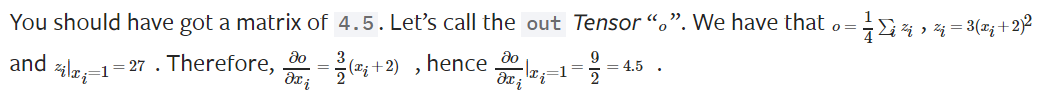

##### 실제로 o의 gradients는 4.5인 것을 확인할 수 있습니다.
##### y = f(x) 함수 값을 갖고 있는 벡터를 갖고 있으면, 수학적으로 x에 대한 y의 변화도는 야코비안 행렬(jacobian matrix)입니다.
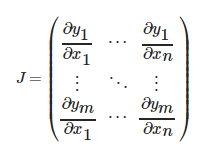

##### 일반적으로 말하면 torch.autograd는 벡터-야코비안 곱(vector-jacobian product)을 계산하는 엔진입니다. 
##### 만약 v가 스칼라 함수 I=g(y)의 기울기이면 연쇄 법칙(chain rult)에 의해 벡터-야코비안 곱(vector-jacobian product)는 x에 관한 I의 변화도 입니다.
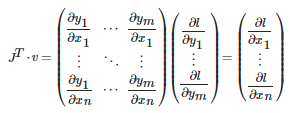
##### 이러한 벡터-야코비안 곱(vector-jacobian product)의 성질은 스칼라가 아닌 출력을 갖고 있는 모델에 외부 기울기를 제공(feed)하는 것을 편리하게 해줍니다.



In [9]:
# 벡터-야코비안 곱(vector-jacobian product)의 예제를 살펴보겠습니다.
x = torch.randn(3, requires_grad=True)
y = x * 2

while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([-802.1501, -130.1089,  684.3704], grad_fn=<MulBackward0>)


In [10]:
# 이 경우 y는 더이상 scalar가 아닙니다.
# torch.autograd는 모든 야코비안을 직접 계산할 수 없지만 벡터-야코비안 곱은 backward에 해당 벡터를 인자로 주어 간단히 벡터-야코비안 곱을 구할 수 있습니다.

v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([5.1200e+01, 5.1200e+02, 5.1200e-02])


In [11]:
# 또한 with torch.no_grad():로 코드 블럭을 감싸서 .requires_grad=True인 Tenosor의 기록을 추적하는 autograd를 중지할 수 있습니다. 
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)


True
True
False


In [12]:
# 또는 .detach()를 사용함으로써 기울기가 필요하지 않지만 같은 항목을 갖고 있는 새로운 Tensor를 얻을 수 있습니다.
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all())


True
False
tensor(True)


##### 추후에 읽을 거리
##### autograd.Function에 대한 문서는 여기에 있습니다.
##### https://pytorch.org/docs/stable/autograd.html#function